# Distributed alternating direction method of multipliers (ADMM)

In [2]:
import os
import json
import math
import copy
import sys
import bokeh
from oedisi.types.data_types import MeasurementArray, AdmittanceMatrix, Topology
import pyarrow.feather as feather
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from pydantic import BaseModel
from plotly.subplots import make_subplots
import glob
from oedisi.componentframework.system_configuration import (
    WiringDiagram,
    Component,
    Link,
)
from lindistflow_federate.adapter import (
    generate_graph,
    area_disconnects,
    disconnect_areas,
    reconnect_area_switches,
    get_area_source,
)
import networkx as nx

from oedisi.componentframework import wiring_diagram_utils

ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
BUILDS = f"{ROOT}/builds"
SCENARIOS = f"{ROOT}/scenarios"

## Select a scenario
Set the SCENARIOS index value from the available scenarios

In [3]:
dir = []
def list_files_scandir(path="."):
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                if "system.json" in entry.path:
                    path, _ = entry.path.split("system.json", 1)
                    dir.append(path)
            elif entry.is_dir():
                list_files_scandir(entry.path)


# Specify the directory path you want to start from
directory_path = f"{SCENARIOS}/lindistflow"
list_files_scandir(directory_path)
for i, d in enumerate(dir):
    print(i, d)

0 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/ieee123/
1 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P9U/low/
2 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P9U/high/
3 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P9U/extreme/
4 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P9U/medium/
5 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P1U/low/
6 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P1U/high/
7 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P1U/extreme/
8 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P1U/medium/
9 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P6U/low/
10 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P6U/high/
11 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P6U/extreme/
12 /home/tylor/dev/oedisi_dopf/scenarios/lindistflow/SFO/P6U/medium/


## Build the selected scenario
The build will create a new build_<scenario> folder and copy over the federate files as specified. Assume successful build if no errors are presented.

In [7]:
index = 0
path = dir[index]
_, scenario = path.split(SCENARIOS, 1)
build = f"{BUILDS}{scenario}"
output = f"{OUTPUTS}{scenario}"
os.system(
    f"oedisi build --system {path}system.json --component-dict {path}components.json --target-directory {build}"
)

Loading the components defined in /home/tylor/oedisi_dopf/scenarios/lindistflow/ieee123/components.json
Loading system json /home/tylor/oedisi_dopf/scenarios/lindistflow/ieee123/system.json
Building system in /home/tylor/oedisi_dopf/builds/lindistflow/ieee123/


0

## Model Topology
split model into areas using discconnection switches

In [5]:
topology_file = f"{output}/topology.json"
with open(topology_file) as f:
    topology = Topology.parse_obj(json.load(f))

In [5]:
import lindistflow_federate.adapter as ada
import copy

def get_system(path: str) -> WiringDiagram:
    with open(path) as f:
        system: WiringDiagram = WiringDiagram.parse_obj(json.load(f))
    return system

slack_bus, _ = topology.slack_bus[0].split(".", 1)

G = ada.generate_graph(topology.incidences, slack_bus)
print("Total: ", G)
graph = copy.deepcopy(G)
graph2 = copy.deepcopy(G)
boundaries = ada.area_disconnects(graph)
areas = ada.disconnect_areas(graph2, boundaries)
areas = ada.reconnect_area_switches(areas, boundaries)

for area in areas:
    print(area)
    src = []
    for u, v, a in boundaries:
        if area.has_edge(u, v):
            print("\t", a["id"])
            src.append((u, v, a))
    su, sv, sa = ada.get_area_source(G, slack_bus, src)
    print("\tsource: ", sa["id"])

Total:  Graph with 130 nodes and 129 edges
Graph with 42 nodes and 41 edges
	 sw2
	 sw3
	source:  sw2
Graph with 20 nodes and 19 edges
	 sw3
	source:  sw3
Graph with 20 nodes and 19 edges
	 sw2
	 sw4
	source:  sw2
Graph with 39 nodes and 38 edges
	 sw4
	 sw5
	source:  sw4
Graph with 17 nodes and 16 edges
	 sw5
	source:  sw5


## Areas

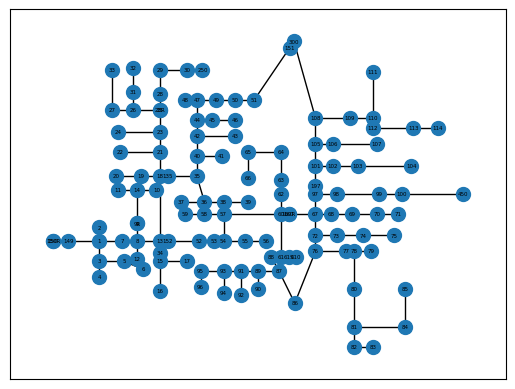

In [6]:
coords_file = f"{output}BusCoords.dat"
pos = {}
with open(coords_file) as f:
    for line in f:
        values = line.split()
        
        # skip comments in file
        if values[0] == "//":
            continue
            
        if len(values) == 3:
            x = float(values[1])
            y = float(values[2])
            pos[values[0].upper()] = (x, y)

options = {
    "font_size": 4,
    "node_size": 100,
    "linewidths": 1,
    "width": 1,
}
nx.draw_networkx(graph, pos, **options)

/home/tylor/.cache/pypoetry/virtualenvs/oedisi-dopf-QHj6sxFf-py3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


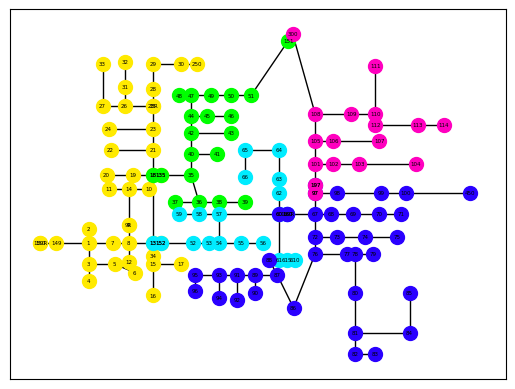

In [7]:
cmap = plt.colormaps["gist_rainbow"]
area_count = len(areas)

fig, ax = plt.subplots()
for i,a in enumerate(areas,1):
    c = cmap(i / area_count)
    nx.draw_networkx(a, pos, **options, node_color=c)

## Generate system.json

In [8]:
MODELS = ["ieee123", "SFO/P1U", "SFO/P6U", "SFO/P9U"]
LEVELS = ["low", "medium", "high", "extreme"]
os.system(f"python generate_admm.py {MODELS[0]}")

['generate_admm.py', 'ieee123']
generating:  ieee123
Total:  Graph with 130 nodes and 129 edges


0

In [9]:
dir = []
def list_files_scandir(path="."):
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                if "system.json" in entry.path:
                    path, _ = entry.path.split("system.json", 1)
                    dir.append(path)
            elif entry.is_dir():
                list_files_scandir(entry.path)

# Specify the directory path you want to start from
directory_path = f"{SCENARIOS}/admm"
list_files_scandir(directory_path)

for i, d in enumerate(dir):
    print(i, d)

0 /home/tylor/dev/oedisi_dopf/scenarios/admm/ieee123/
1 /home/tylor/dev/oedisi_dopf/scenarios/admm/SFO/P1U/low/
2 /home/tylor/dev/oedisi_dopf/scenarios/admm/SFO/P1U/high/
3 /home/tylor/dev/oedisi_dopf/scenarios/admm/SFO/P1U/extreme/
4 /home/tylor/dev/oedisi_dopf/scenarios/admm/SFO/P1U/medium/
5 /home/tylor/dev/oedisi_dopf/scenarios/admm/SFO/P6U/low/


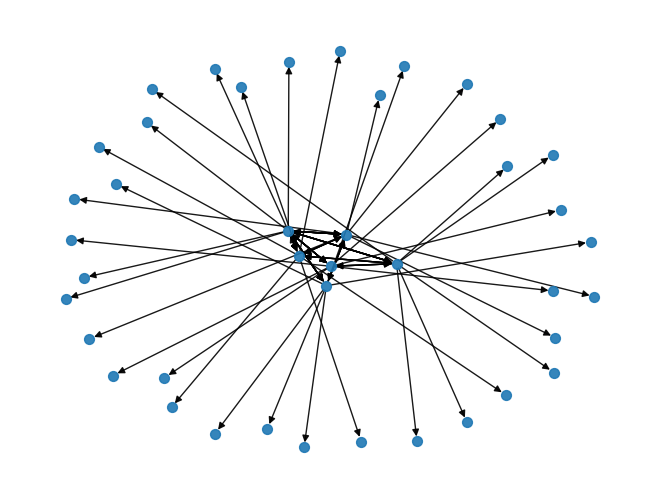

In [24]:
index = 0
path = dir[index]
_, scenario = path.split(SCENARIOS, 1)
build = f"{BUILDS}{scenario}"
output = f"{OUTPUTS}{scenario}"

def get_system(path: str) -> WiringDiagram:
    with open(path) as f:
        system: WiringDiagram = WiringDiagram.parse_obj(json.load(f))
    return system

def plot_graph(graph: nx.Graph):
    pos = nx.spring_layout(graph,k=0.75)
    nx.draw(
        graph,
        pos,
        edge_color="black",
        width=1,
        linewidths=1,
        node_size=50,
        alpha=0.9,
    )

    edge_map = {
        (l.source, l.target): f"{l.source_port} -> {l.target_port}"
        for l in wiring_diagram.links
    }

    #nx.draw_networkx_edge_labels(g, pos, edge_map, font_color="red")
    plt.axis("off")
    plt.show()

system = get_system(f"{path}system.json")
graph = wiring_diagram_utils.get_graph(system)
plot_graph(graph)

## Run selected scenario
The simulation will take 5-30 minutes to run depending on the scenario. The results will print Done once complete.

NameError: name 'SCENARIO' is not defined